In [81]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [82]:
!pip install dill

In [83]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator ,load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import os
import numpy as np
from tensorflow.keras.regularizers import l2 , l1
from tensorflow.keras.applications import VGG16 , VGG19 , ResNet50 ,EfficientNetB0
import dill
from collections import Counter
from sklearn.model_selection import train_test_split
import json

In [84]:
data_dir = '/content/drive/MyDrive/Research Project/Data'
img_height = 128
img_width = 128
batch_size = 32

In [85]:
class_names = os.listdir(data_dir)

In [86]:
class_names

['Acne', 'Non Acne']

In [87]:
class_counts = {}

In [88]:
# Count the number of images in each class directory
for class_name in class_names:
    class_path = os.path.join(data_dir, class_name)
    if os.path.isdir(class_path):  # Check if it is a directory
        class_counts[class_name] = len(os.listdir(class_path))

In [89]:
# Display the class counts
for class_name, count in class_counts.items():
    print(f"Class '{class_name}': {count} images")

# Optionally, check for imbalance
total_images = sum(class_counts.values())
print(f"Total images: {total_images}")
for class_name, count in class_counts.items():
    print(f"Proportion of class '{class_name}': {count / total_images:.2%}")

Class 'Acne': 1037 images
Class 'Non Acne': 1037 images
Total images: 2074
Proportion of class 'Acne': 50.00%
Proportion of class 'Non Acne': 50.00%


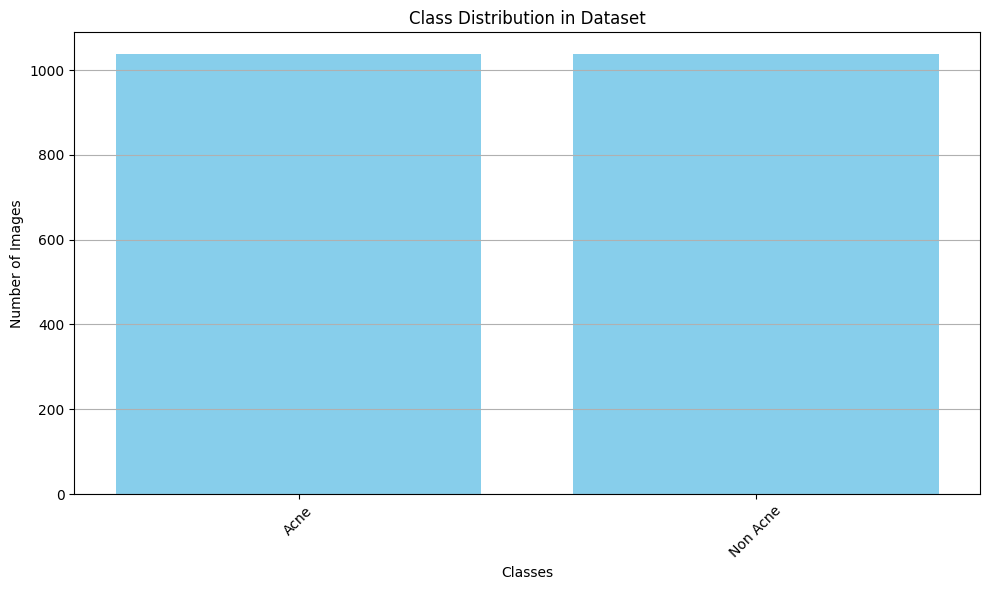

In [10]:
# Plotting the class counts
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.title('Class Distribution in Dataset')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [90]:
# datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [91]:
# Data augmentation for the training set
datagen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,        # Randomly rotate images
    width_shift_range=0.2,    # Randomly shift images horizontally
    height_shift_range=0.2,   # Randomly shift images vertically
    shear_range=0.2,          # Apply shear transformations
    zoom_range=0.2,           # Random zoom
    horizontal_flip=True,      # Randomly flip images
    fill_mode='nearest',       # Fill in new pixels
    validation_split=0.2       # Split for validation
)

In [92]:
# Create training set
train_ds = datagen_train.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

Found 1660 images belonging to 2 classes.
Found 1660 images belonging to 2 classes.


In [93]:
# Create validation set
val_ds = datagen_train.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

Found 414 images belonging to 2 classes.
Found 414 images belonging to 2 classes.


In [94]:
# # Get a batch of images and labels from the training dataset
# x_batch, y_batch = next(train_ds)

# # Function to plot images
# def plot_augmented_images(images, labels):
#     plt.figure(figsize=(12, 6))
#     for i in range(10):  # Display 10 images
#         plt.subplot(2, 5, i + 1)
#         plt.imshow(images[i])
#         plt.title(f'Label: {labels[i]}')
#         plt.axis('off')
#     plt.tight_layout()
#     plt.show()

# # Plot augmented images
# plot_augmented_images(x_batch, y_batch)

In [95]:
# train_ds = datagen.flow_from_directory(
#     data_dir,
#     target_size=(img_height, img_width),
#     batch_size=batch_size,
#     class_mode='binary',
#     subset='training'

# )

In [96]:
# val_ds = datagen.flow_from_directory(
#     data_dir,
#     target_size=(img_height, img_width),
#     batch_size=batch_size,
#     class_mode='binary',
#     subset='validation'
# )

In [97]:
train_ds.class_indices

{'Acne': 0, 'Non Acne': 1}

{'Acne': 0, 'Non Acne': 1}

In [98]:
val_ds.class_indices

{'Acne': 0, 'Non Acne': 1}

{'Acne': 0, 'Non Acne': 1}

In [99]:
class_names = train_ds.class_indices
class_names

{'Acne': 0, 'Non Acne': 1}

{'Acne': 0, 'Non Acne': 1}

In [100]:
y_true_train = train_ds.classes
y_true_val = val_ds.classes

In [101]:
train_class_counts = np.bincount(y_true_train)
val_class_counts = np.bincount(y_true_val)

In [102]:
train_class_counts = np.bincount(y_true_train)
val_class_counts = np.bincount(y_true_val)

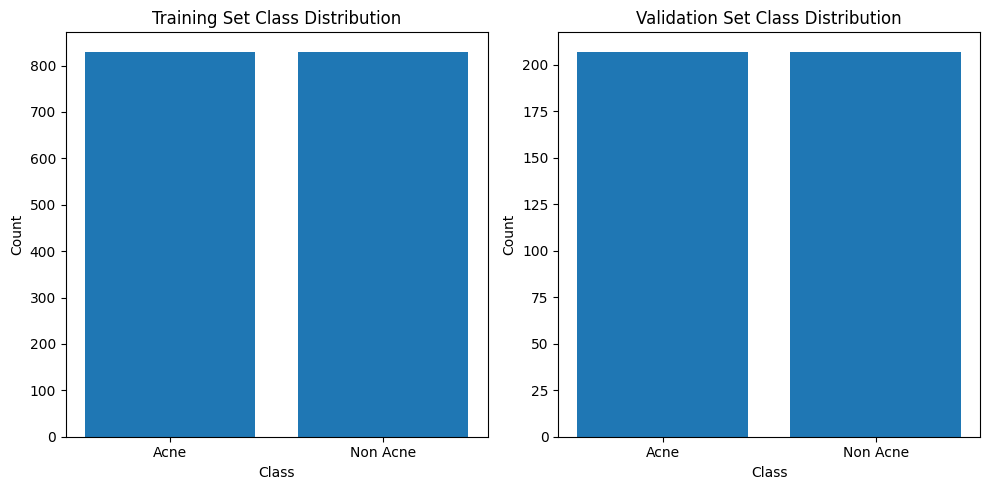

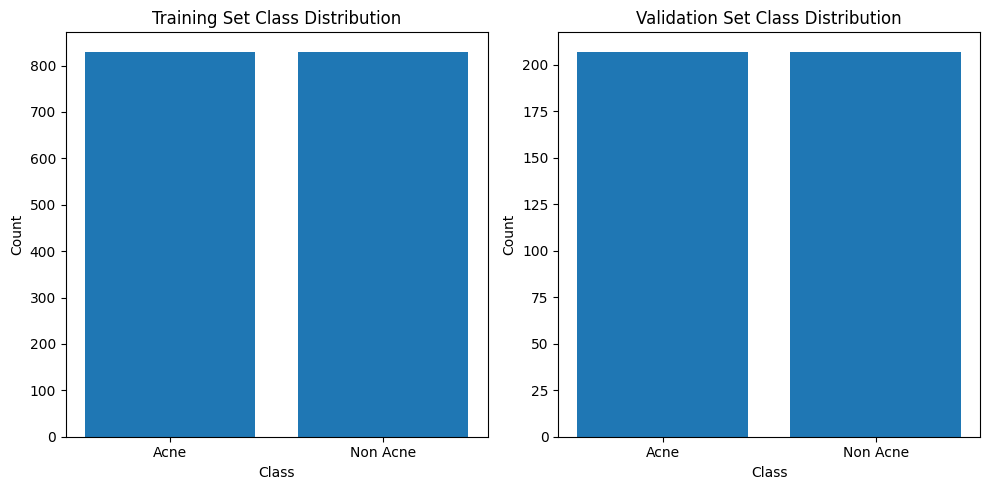

In [103]:
# Plotting the class distribution
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.bar(train_ds.class_indices.keys(), train_class_counts)
plt.title('Training Set Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.bar(val_ds.class_indices.keys(), val_class_counts)
plt.title('Validation Set Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


In [104]:
# plt.figure(figsize=(10, 10))


# images, labels = next(train_ds)

# for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(images[i])
#     plt.title(list(class_names.keys())[list(class_names.values()).index(int(labels[i]))])
#     plt.axis("off")

# plt.show()

#Models

##CNN

In [105]:
# model_cnn = Sequential([
#     data_augmentation,
#     Conv2D(16, 3, padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
#     MaxPooling2D(),
#     Conv2D(32, 3, padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
#     MaxPooling2D(),
#     Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
#     MaxPooling2D(),
#     Conv2D(128, 3, padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
#     MaxPooling2D(),
#     Dropout(0.2),
#     Flatten(input_shape=(18, 18, 64)),
#     Dense(128, activation='relu'),
#     Dropout(0.3),
#     Dense(1, activation='sigmoid')
# ])

In [106]:
model_cnn = Sequential()

In [107]:
model_cnn.add(tf.keras.layers.Conv2D(filters=32,kernel_size=3,padding='same',activation='relu',input_shape=[128,128,3],kernel_regularizer=tf.keras.regularizers.l1(0.001)))
model_cnn.add(tf.keras.layers.Conv2D(filters=32,kernel_size=3,activation='relu'))
model_cnn.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=2))

model_cnn.add(tf.keras.layers.Conv2D(filters=64,kernel_size=3,padding='same',activation='relu',kernel_regularizer=tf.keras.regularizers.l1(0.001)))
model_cnn.add(tf.keras.layers.Conv2D(filters=64,kernel_size=3,activation='relu'))
model_cnn.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=2))

model_cnn.add(tf.keras.layers.Conv2D(filters=128,kernel_size=3,padding='same',activation='relu',kernel_regularizer=tf.keras.regularizers.l1(0.001)))
model_cnn.add(tf.keras.layers.Conv2D(filters=128,kernel_size=3,activation='relu'))
model_cnn.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=2))

model_cnn.add(tf.keras.layers.Conv2D(filters=256,kernel_size=3,padding='same',activation='relu',kernel_regularizer=tf.keras.regularizers.l1(0.001)))
model_cnn.add(tf.keras.layers.Conv2D(filters=256,kernel_size=3,activation='relu'))
model_cnn.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=2))

model_cnn.add(tf.keras.layers.Conv2D(filters=512,kernel_size=3,padding='same',activation='relu',kernel_regularizer=tf.keras.regularizers.l1(0.001)))
model_cnn.add(tf.keras.layers.Conv2D(filters=512,kernel_size=3,activation='relu'))
model_cnn.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=2))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [108]:
model_cnn.add(tf.keras.layers.Dropout(0.25))

model_cnn.add(tf.keras.layers.Flatten())

model_cnn.add(tf.keras.layers.Dense(units=1500,activation='relu'))

model_cnn.add(tf.keras.layers.Dropout(0.4)) #To avoid overfitting

#Output Layer
model_cnn.add(tf.keras.layers.Dense(units=1,activation='sigmoid'))

In [109]:
model_cnn.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [110]:
model_cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 126, 126, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 63, 63, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 61, 61, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 30, 30, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 28, 28, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 14, 14, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 6, 6, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1500)                │       3,073,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1500)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │           1,501 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,787,225 (29.71 MB)

 Trainable params: 7,787,225 (29.71 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 126, 126, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 63, 63, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 61, 61, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 30, 30, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 28, 28, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 14, 14, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 6, 6, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 1500)                │       3,073,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 1500)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │           1,501 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,787,225 (29.71 MB)

 Trainable params: 7,787,225 (29.71 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
epochs_cnn = 10
history_cnn = model_cnn.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs_cnn
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


52/52 ━━━━━━━━━━━━━━━━━━━━ 395s 7s/step - accuracy: 0.5194 - loss: 25.2457 - val_accuracy: 0.8043 - val_loss: 19.8459
Epoch 2/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 356s 6s/step - accuracy: 0.8461 - loss: 18.5075 - val_accuracy: 0.8816 - val_loss: 14.6955
Epoch 3/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 318s 6s/step - accuracy: 0.8469 - loss: 13.7030 - val_accuracy: 0.8816 - val_loss: 10.7499
Epoch 4/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 303s 6s/step - accuracy: 0.8703 - loss: 9.9474 - val_accuracy: 0.8696 - val_loss: 7.7078
Epoch 5/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 311s 6s/step - accuracy: 0.9010 - loss: 7.0957 - val_accuracy: 0.8671 - val_loss: 5.6070
Epoch 6/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 327s 6s/step - accuracy: 0.8952 - loss: 5.1942 - val_accuracy: 0.9155 - val_loss: 4.2425
Epoch 7/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 291s 5s/step - accuracy: 0.9064 - loss: 4.0159 - val_accuracy: 0.8913 - val_loss: 3.4404
Epoch 8/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 325s 5s/step - accuracy: 0.8983 - loss: 3.2697 - val_accuracy: 0.8768 - val_lo

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11/52 ━━━━━━━━━━━━━━━━━━━━ 4:01 6s/step - accuracy: 0.5297 - loss: 26.8281

In [33]:
#recording history
with open('history_cnn.json', 'w') as f:
    json.dump(history_cnn.history, f)

In [34]:
model_cnn.save('model_cnn.h5')

##VGG16

In [35]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = False

model_vgg16 = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [36]:
model_vgg16.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [37]:
model_vgg16.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 4, 4, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       1,048,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,763,521 (60.13 MB)

 Trainable params: 1,048,833 (4.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [38]:
epochs_vgg16 = 5
history_vgg16 = model_vgg16.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs_vgg16
)

Epoch 1/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 457s 9s/step - accuracy: 0.7445 - loss: 0.6563 - val_accuracy: 0.9348 - val_loss: 0.1668
Epoch 2/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 446s 8s/step - accuracy: 0.9474 - loss: 0.1377 - val_accuracy: 0.9517 - val_loss: 0.1278
Epoch 3/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 448s 8s/step - accuracy: 0.9550 - loss: 0.1160 - val_accuracy: 0.9493 - val_loss: 0.1270
Epoch 4/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 500s 8s/step - accuracy: 0.9573 - loss: 0.1211 - val_accuracy: 0.9589 - val_loss: 0.1111
Epoch 5/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 448s 8s/step - accuracy: 0.9580 - loss: 0.1213 - val_accuracy: 0.9300 - val_loss: 0.1633


In [39]:
# recording history
with open('history_vgg16.json', 'w') as f:
    json.dump(history_vgg16.history, f)

In [40]:
model_vgg16.save('model_vgg16.h5')

##VGG19

In [41]:
base_model_vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model_vgg19.trainable = False

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [42]:
model_vgg19 = Sequential([
    base_model_vgg19,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

In [43]:
model_vgg19.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
model_vgg19.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)                   │ (None, 4, 4, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       1,048,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,073,217 (80.39 MB)

 Trainable params: 1,048,833 (4.00 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [44]:
epochs_vgg19 = 10
history_vgg19 = model_vgg19.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs_vgg19
)

Epoch 1/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 583s 11s/step - accuracy: 0.7291 - loss: 0.6685 - val_accuracy: 0.9420 - val_loss: 0.1611
Epoch 2/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 577s 11s/step - accuracy: 0.9285 - loss: 0.1735 - val_accuracy: 0.8140 - val_loss: 0.4730
Epoch 3/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 589s 10s/step - accuracy: 0.9365 - loss: 0.1684 - val_accuracy: 0.9517 - val_loss: 0.1349
Epoch 4/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 577s 11s/step - accuracy: 0.9284 - loss: 0.1849 - val_accuracy: 0.9734 - val_loss: 0.1147
Epoch 5/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 577s 11s/step - accuracy: 0.9511 - loss: 0.1393 - val_accuracy: 0.9372 - val_loss: 0.1414
Epoch 6/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 578s 11s/step - accuracy: 0.9533 - loss: 0.1102 - val_accuracy: 0.9710 - val_loss: 0.0923
Epoch 7/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 586s 10s/step - accuracy: 0.9551 - loss: 0.1379 - val_accuracy: 0.9251 - val_loss: 0.1948
Epoch 8/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 542s 10s/step - accuracy: 0.9709 - loss: 0.0871 - val_accuracy: 0.

In [45]:
#Recording History
with open('history_vgg19.json', 'w') as f:
    json.dump(history_vgg19.history, f)

In [46]:
model_vgg19.save('model_vgg19.h5')

##ResNet

In [47]:
base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model_resnet.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [48]:
model_resnet = Sequential([
    base_model_resnet,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])


In [49]:
model_resnet.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
model_resnet.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 4, 4, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │       4,194,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 27,782,273 (105.98 MB)

 Trainable params: 4,194,561 (16.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [50]:
epochs_resnet = 10
history_resnet = model_resnet.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs_resnet
)

Epoch 1/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 195s 3s/step - accuracy: 0.5183 - loss: 0.9187 - val_accuracy: 0.6957 - val_loss: 0.6874
Epoch 2/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 203s 3s/step - accuracy: 0.5841 - loss: 0.6650 - val_accuracy: 0.5048 - val_loss: 0.6876
Epoch 3/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 187s 3s/step - accuracy: 0.6139 - loss: 0.6373 - val_accuracy: 0.4928 - val_loss: 0.6753
Epoch 4/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 176s 3s/step - accuracy: 0.6575 - loss: 0.6198 - val_accuracy: 0.6377 - val_loss: 0.6369
Epoch 5/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 216s 3s/step - accuracy: 0.6872 - loss: 0.5768 - val_accuracy: 0.6401 - val_loss: 0.6134
Epoch 6/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 187s 3s/step - accuracy: 0.7342 - loss: 0.5651 - val_accuracy: 0.8140 - val_loss: 0.5654
Epoch 7/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 178s 3s/step - accuracy: 0.7788 - loss: 0.5130 - val_accuracy: 0.7657 - val_loss: 0.5650
Epoch 8/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 208s 3s/step - accuracy: 0.7522 - loss: 0.5281 - val_accuracy: 0.5700 - v

In [51]:
#Recording History
with open('history_resnet.json', 'w') as f:
    json.dump(history_resnet.history, f)

In [52]:
model_resnet.save('model_resnet.h5')

##EfficientNetB0

In [53]:
base_model_efficientnet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model_efficientnet.trainable = False

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [54]:
model_efficientnet = Sequential([
    base_model_efficientnet,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

In [55]:
model_efficientnet.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
model_efficientnet.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 4, 4, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 20480)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │       2,621,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,671,268 (25.45 MB)

 Trainable params: 2,621,697 (10.00 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [56]:
epochs_efficientnet = 10
history_efficientnet = model_efficientnet.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs_efficientnet
)

Epoch 1/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 150s 2s/step - accuracy: 0.5168 - loss: 2.1123 - val_accuracy: 0.5000 - val_loss: 0.6944
Epoch 2/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step - accuracy: 0.5123 - loss: 0.6914 - val_accuracy: 0.5000 - val_loss: 0.6936
Epoch 3/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.5097 - loss: 0.6950 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 4/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.5033 - loss: 0.6944 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 5/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 112s 2s/step - accuracy: 0.5246 - loss: 0.6929 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 6/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.4753 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 7/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - accuracy: 0.4989 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 8/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - accuracy: 0.5028 - loss: 0.6931 - val_accuracy: 0.5000 - v

In [57]:
#Recording History
with open('history_efficientnet.json', 'w') as f:
    json.dump(history_efficientnet.history, f)

In [58]:
model_efficientnet.save('model_efficientnet.h5')

##Visualization

In [59]:
#CNN

acc_cnn = history_cnn.history['accuracy']
val_acc_cnn = history_cnn.history['val_accuracy']

loss_cnn = history_cnn.history['loss']
val_loss_cnn = history_cnn.history['val_loss']

# VGG16
acc_vgg16 = history_vgg16.history['accuracy']
val_acc_vgg16 = history_vgg16.history['val_accuracy']

loss_vgg16 = history_vgg16.history['loss']
val_loss_vgg16 = history_vgg16.history['val_loss']

#VGG19
acc_vgg19 = history_vgg19.history['accuracy']
val_acc_vgg19 = history_vgg19.history['val_accuracy']

loss_vgg19 = history_vgg19.history['loss']
val_loss_vgg19 = history_vgg19.history['val_loss']

#ResNet
acc_resnet = history_resnet.history['accuracy']
val_acc_resnet = history_resnet.history['val_accuracy']

loss_resnet = history_resnet.history['loss']
val_loss_resnet = history_resnet.history['val_loss']

#EfficientNetB0
acc_efficientnet = history_efficientnet.history['accuracy']
val_acc_efficientnet = history_efficientnet.history['val_accuracy']

loss_efficientnet = history_efficientnet.history['loss']
val_loss_efficientnet = history_efficientnet.history['val_loss']





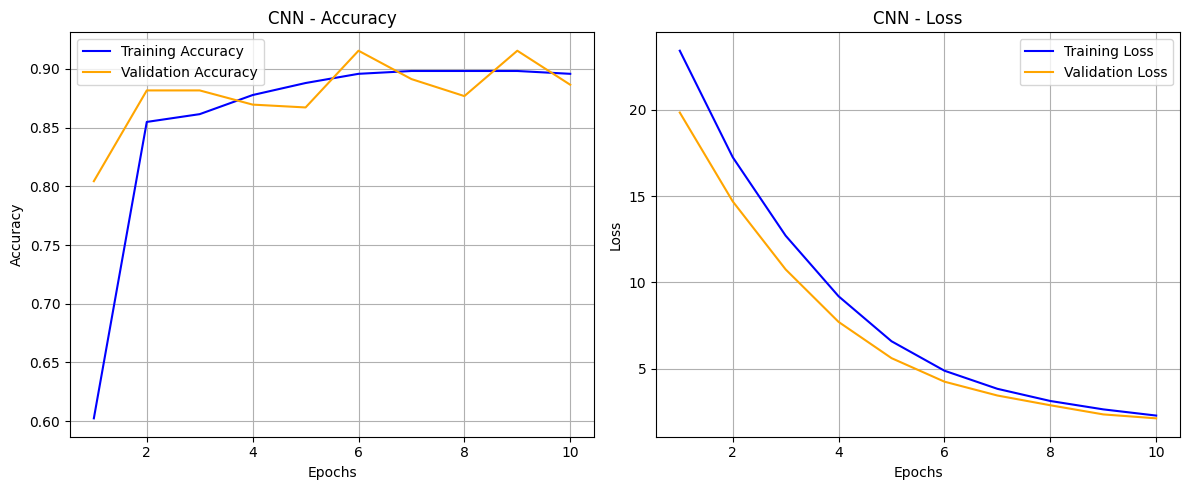

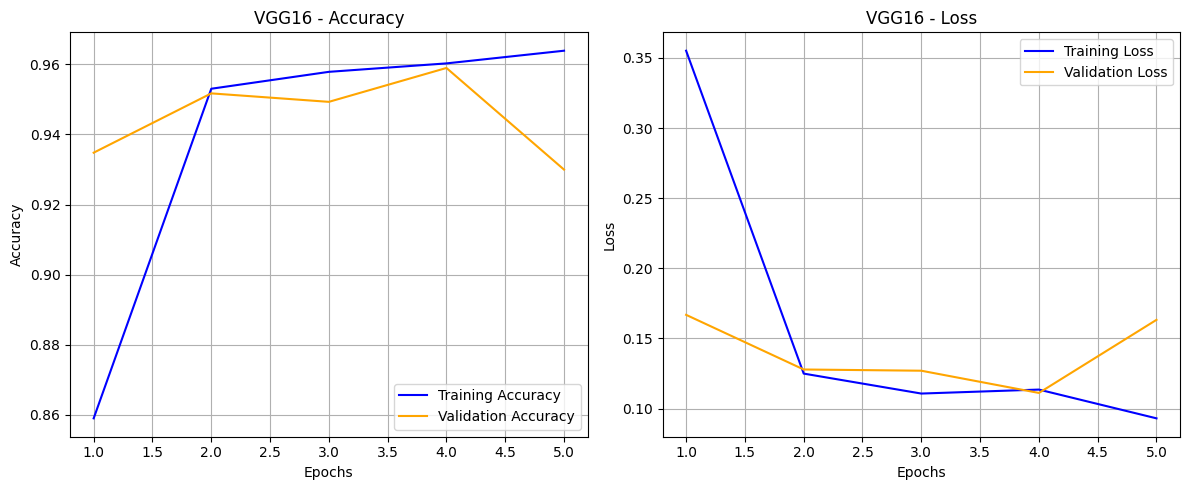

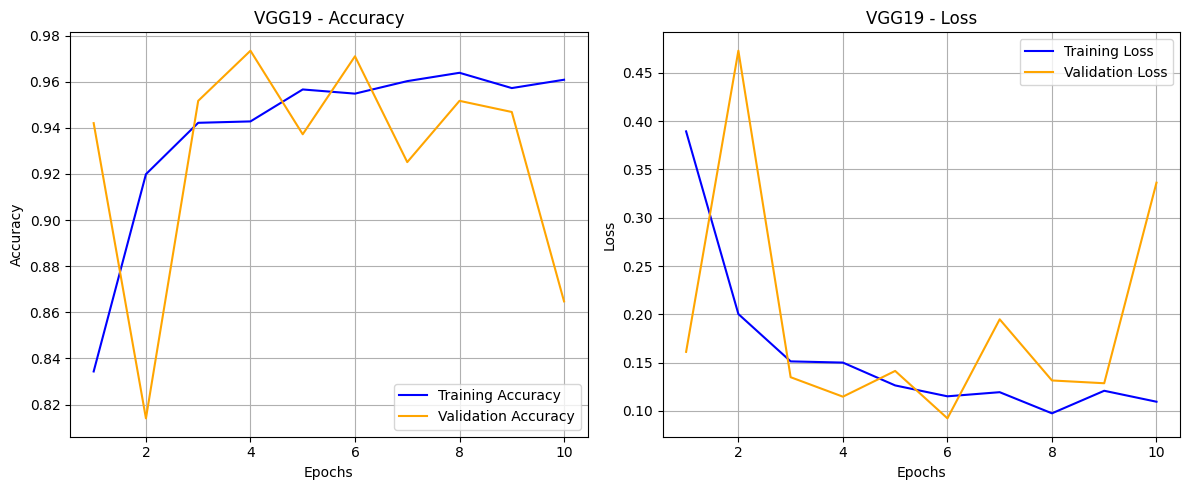

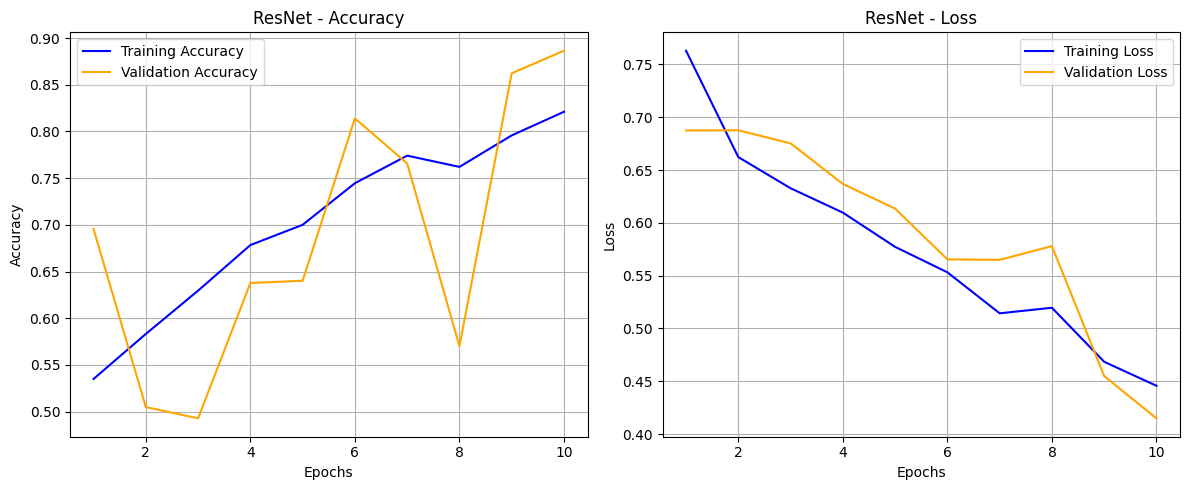

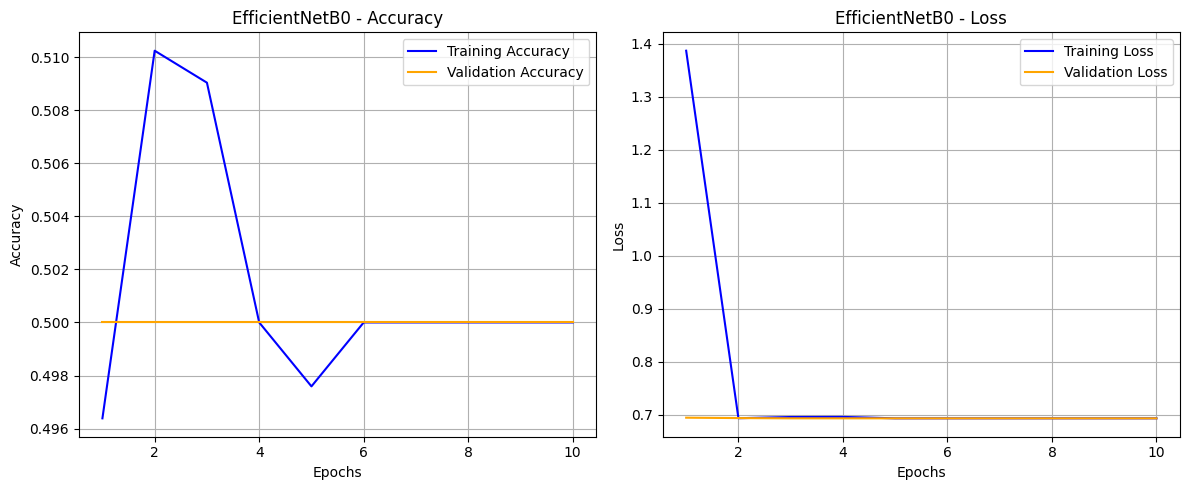

In [60]:

# Function to plot accuracy and loss for a model
def plot_model_history(train_acc, val_acc, train_loss, val_loss, model_name):
    epochs = range(1, len(train_acc) + 1)

    # Create a figure for accuracy
    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, label='Training Accuracy', color='blue')
    plt.plot(epochs, val_acc, label='Validation Accuracy', color='orange')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, label='Training Loss', color='blue')
    plt.plot(epochs, val_loss, label='Validation Loss', color='orange')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

# Plot for CNN
plot_model_history(acc_cnn, val_acc_cnn, loss_cnn, val_loss_cnn, 'CNN')

#plot for VGG16
plot_model_history(acc_vgg16, val_acc_vgg16, loss_vgg16, val_loss_vgg16, 'VGG16')

# Plot for VGG19
plot_model_history(acc_vgg19, val_acc_vgg19, loss_vgg19, val_loss_vgg19, 'VGG19')

# Plot for ResNet
plot_model_history(acc_resnet, val_acc_resnet, loss_resnet, val_loss_resnet, 'ResNet')

# Plot for EfficientNetB0
plot_model_history(acc_efficientnet, val_acc_efficientnet, loss_efficientnet, val_loss_efficientnet, 'EfficientNetB0')

13/13 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step


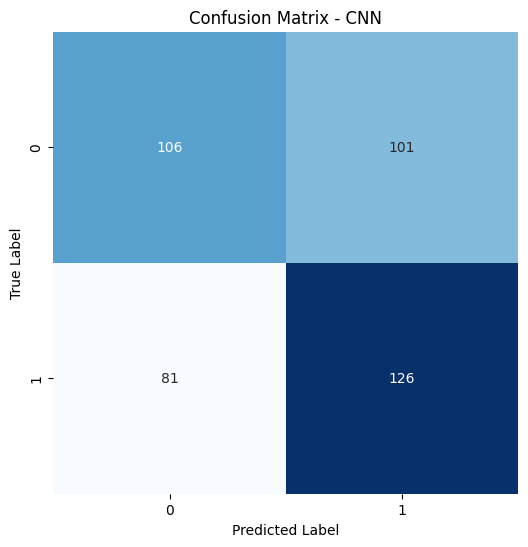

13/13 ━━━━━━━━━━━━━━━━━━━━ 85s 6s/step


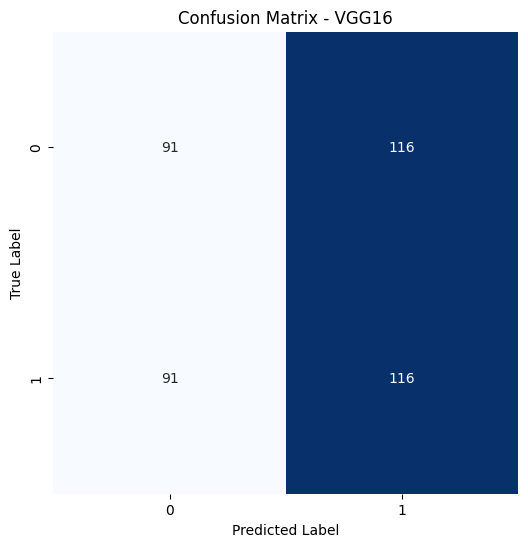

13/13 ━━━━━━━━━━━━━━━━━━━━ 106s 8s/step


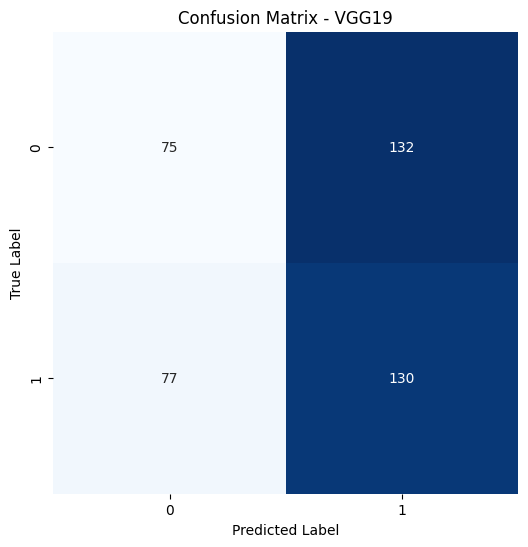

13/13 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step


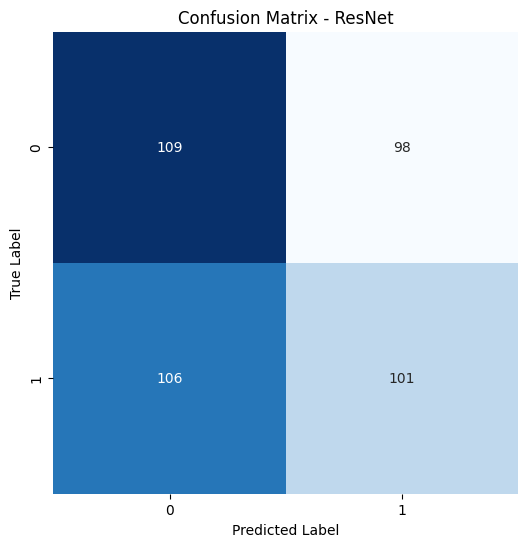

13/13 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step


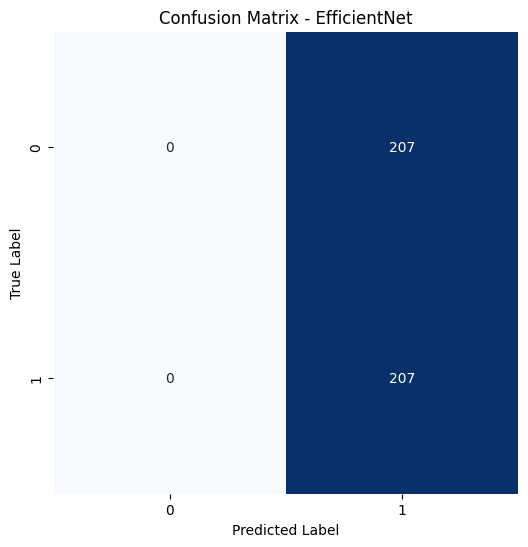

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, history, val_ds, model_name):
  """Generates and plots a confusion matrix."""

  # Get the predictions
  y_pred = model.predict(val_ds)
  y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to class labels (0 or 1)

  # Get the true labels
  y_true = val_ds.classes

  # Generate the confusion matrix
  cm = confusion_matrix(y_true, y_pred)

  # Plot the confusion matrix
  plt.figure(figsize=(6, 6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
  plt.title(f'Confusion Matrix - {model_name}')
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  plt.show()


# Generate confusion matrices for each model
plot_confusion_matrix(model_cnn, history_cnn, val_ds, "CNN")
plot_confusion_matrix(model_vgg16, history_vgg16, val_ds, "VGG16")
plot_confusion_matrix(model_vgg19, history_vgg19, val_ds, "VGG19")
plot_confusion_matrix(model_resnet, history_resnet, val_ds, "ResNet")
plot_confusion_matrix(model_efficientnet, history_efficientnet, val_ds, "EfficientNet")

In [62]:
from sklearn.metrics import confusion_matrix, classification_report

def get_classification_report(model, val_ds, model_name):
  """Calculates and prints the classification report."""

  y_pred = model.predict(val_ds)
  y_pred = (y_pred > 0.5).astype(int)
  y_true = val_ds.classes

  # Generate and print the classification report
  report = classification_report(y_true, y_pred, target_names=train_ds.class_indices)
  print(f"Classification Report - {model_name}:\n{report}")


# Get classification reports for each model
get_classification_report(model_cnn, val_ds, "CNN")
get_classification_report(model_vgg16, val_ds, "VGG16")
get_classification_report(model_vgg19, val_ds, "VGG19")
get_classification_report(model_resnet, val_ds, "ResNet")
get_classification_report(model_efficientnet, val_ds, "EfficientNet")

13/13 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step
Classification Report - CNN:
              precision    recall  f1-score   support

        Acne       0.51      0.43      0.46       207
    Non Acne       0.50      0.58      0.54       207

    accuracy                           0.50       414
   macro avg       0.50      0.50      0.50       414
weighted avg       0.50      0.50      0.50       414

13/13 ━━━━━━━━━━━━━━━━━━━━ 85s 7s/step
Classification Report - VGG16:
              precision    recall  f1-score   support

        Acne       0.52      0.46      0.49       207
    Non Acne       0.52      0.57      0.54       207

    accuracy                           0.52       414
   macro avg       0.52      0.52      0.52       414
weighted avg       0.52      0.52      0.52       414

13/13 ━━━━━━━━━━━━━━━━━━━━ 105s 8s/step
Classification Report - VGG19:
              precision    recall  f1-score   support

        Acne       0.44      0.33      0.38       207
    Non Acne       0.46     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


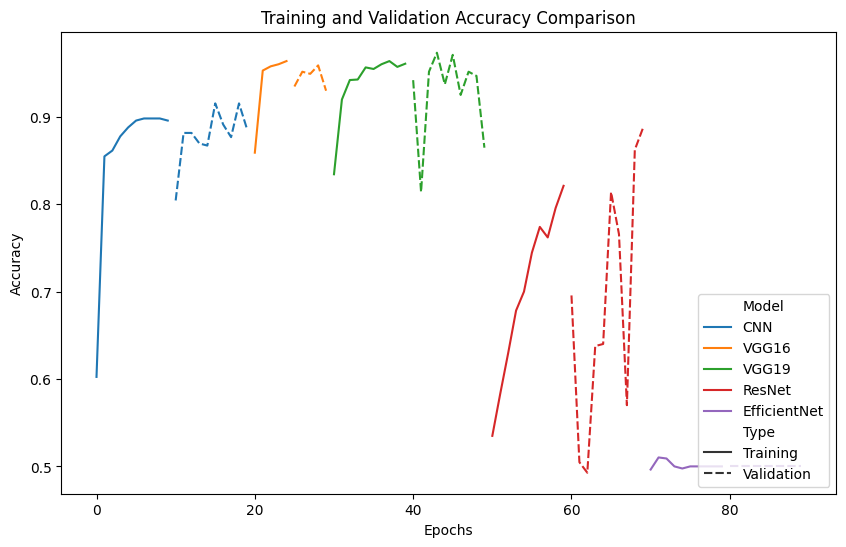

In [63]:
import matplotlib.pyplot as plt
import pandas as pd

# Extract accuracy values from history objects
histories = [history_cnn, history_vgg16, history_vgg19, history_resnet, history_efficientnet]
model_names = ["CNN", "VGG16", "VGG19", "ResNet", "EfficientNet"]
data = []

for history, model_name in zip(histories, model_names):
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    data.extend([
        {"Model": model_name, "Accuracy": acc, "Type": "Training"} for acc in train_acc
    ])
    data.extend([
        {"Model": model_name, "Accuracy": acc, "Type": "Validation"} for acc in val_acc
    ])

# Create a DataFrame
df = pd.DataFrame(data)

# Plot the accuracies
plt.figure(figsize=(10, 6))
sns.lineplot(x=df.index, y="Accuracy", hue="Model", style="Type", data=df)
plt.title("Training and Validation Accuracy Comparison")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.show()

#Best Model

In [64]:
cnn_accuracy = history_cnn.history['val_accuracy'][-1]
vgg16_accuracy = history_vgg16.history['val_accuracy'][-1]
vgg19_accuracy = history_vgg19.history['val_accuracy'][-1]
resnet_accuracy = history_resnet.history['val_accuracy'][-1]
efficientnet_accuracy = history_efficientnet.history['val_accuracy'][-1]

In [65]:
print(f"CNN Accuracy: {cnn_accuracy:.4f}")
print(f"VGG16 Accuracy: {vgg16_accuracy:.4f}")
print(f"VGG19 Accuracy: {vgg19_accuracy:.4f}")
print(f"EfficientNetB0 Accuracy: {efficientnet_accuracy:.4f}")

CNN Accuracy: 0.8865
VGG16 Accuracy: 0.9300
VGG19 Accuracy: 0.8647
EfficientNetB0 Accuracy: 0.5000


In [66]:
# best_accuracy = max(cnn_accuracy, vgg16_accuracy, vgg19_accuracy, resnet_accuracy, efficientnet_accuracy)
best_accuracy = max(cnn_accuracy, vgg19_accuracy, resnet_accuracy, efficientnet_accuracy)


In [67]:
if best_accuracy == cnn_accuracy:
    best_model = model_cnn
    print("CNN model has the highest accuracy.")
elif best_accuracy == vgg16_accuracy:
    best_model = model_vgg16
    print("VGG16 model has the highest accuracy.")
elif best_accuracy == vgg19_accuracy:
    best_model = model_vgg19
    print("VGG19 model has the highest accuracy.")
elif best_accuracy == resnet_accuracy:
    best_model = model_resnet
    print("ResNet50 model has the highest accuracy.")
else:
    best_model = model_efficientnet
    print("EfficientNetB0 model has the highest accuracy.")

CNN model has the highest accuracy.


In [68]:
print(class_names)

{'Acne': 0, 'Non Acne': 1}


Shape of first_image: (128, 128, 3)
Data type of first_image: float32
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


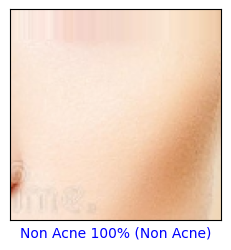

Actual label: Non Acne
Predicted label: Non Acne


In [69]:
images_batch, labels_batch = next(val_ds)

first_image = images_batch[0]
first_label = labels_batch[0]

print("Shape of first_image:", first_image.shape)
print("Data type of first_image:", first_image.dtype)

prediction = best_model.predict(np.expand_dims(first_image.astype('float32'), axis=0))

def plot_image(prediction, true_label, img):
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = 1 if prediction[0][0] > 0.5 else 0
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    class_names_list = ['Acne', 'Non Acne']

    plt.xlabel("{} {:2.0f}% ({})".format(class_names_list[predicted_label],
                                         100*np.max(prediction),
                                         class_names_list[int(true_label)]),color=color)


plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plot_image(prediction, first_label, first_image)
plt.show()


class_names_list = ['Acne', 'Non Acne']
actual_label = class_names_list[int(first_label)]
print("Actual label:", actual_label)


predicted_label = class_names_list[1 if prediction[0][0] > 0.5 else 0]
print("Predicted label:", predicted_label)

In [70]:
sample_image_path = '/content/drive/MyDrive/Research Project/Testing Data/image5.jpg'
img = load_img(sample_image_path, target_size=(img_height, img_width))
img_array = img_to_array(img)
img_array = img_array / 255.0
img_array = np.expand_dims(img_array, axis=0)

In [71]:
prediction = best_model.predict(img_array)

predicted_class_index = 1 if prediction[0][0] > 0.5 else 0
class_names_list = ['Acne', 'Non Acne']
predicted_label = class_names_list[predicted_class_index]

print("Predicted Output:", predicted_label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Predicted Output: Non Acne


In [72]:
# def predict_acne(image_path):

#   img = load_img(image_path, target_size=(img_height, img_width))
#   img_array = img_to_array(img)
#   img_array = img_array / 255.0
#   img_array = np.expand_dims(img_array, axis=0)
#   prediction = model.predict(img_array)

#   return prediction[0][0]

In [73]:
# sample_images = [
#     '/content/drive/MyDrive/Research Project/Testing Data/image1.jpg',
#     '/content/drive/MyDrive/Research Project/Testing Data/image2.jpg',
#     '/content/drive/MyDrive/Research Project/Testing Data/image3.jpg',
#     '/content/drive/MyDrive/Research Project/Testing Data/image4.jpg',
#     '/content/drive/MyDrive/Research Project/Testing Data/image5.jpg'
# ]


In [74]:
# for image_path in sample_images:
#   prediction = predict_acne(image_path)

#   # Determine the predicted class and print the output
#   predicted_class_index = 1 if prediction > 0.5 else 0
#   predicted_label = class_names_list[predicted_class_index]

#   # Calculate and print the accuracy as a percentage
#   accuracy = prediction if predicted_class_index == 0 else (1 - prediction)   # Probability of correct class
#   print(f"Image: {image_path}, Predicted Output: {predicted_label}, Accuracy: {accuracy*100:.2f}%")

In [75]:
y_true = val_ds.classes
y_pred = (best_model.predict(val_ds) > 0.5).astype("int32")

13/13 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step


In [76]:
# Calculate the metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Accuracy: 0.5217
Precision: 0.5188
Recall: 0.5990
F1-score: 0.5561


In [77]:
# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

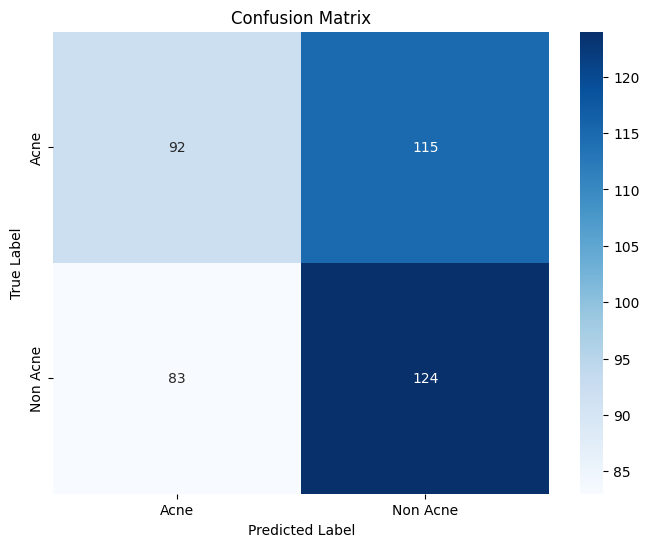

In [78]:
# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names_list,yticklabels=class_names_list)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [79]:
# save the model using dill
with open('acne_detection_model.pkl', 'wb') as f:
    dill.dump(best_model, f)

# Load the model using dill
with open('acne_detection_model.pkl', 'rb') as f:
    best_model = dill.load(f)


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 26 variables whereas the saved optimizer has 50 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [80]:
best_model.save('acne_detection_model.h5')